# Prepare Environment

In [ ]:
import numpy as np
print( f"NumPy {np.__version__}\n" )
np.random.seed(42)

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )
tf.random.set_seed(42)


NumPy 1.26.4

TensorFlow 2.17.0
tf.keras.backend.image_data_format() = channels_last


In [ ]:
import sys
print( f"Python {sys.version}\n" )


import matplotlib.pyplot as plt
%matplotlib inline


from collections import Counter
import os

from imblearn.over_sampling import RandomOverSampler
from collections import defaultdict
from transformers import AutoImageProcessor, TFViTModel
from tensorflow.keras import layers

import datetime
import time


'''# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )'''

Python 3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]



'# Count the number of GPUs as detected by tensorflow\ngpus = tf.config.list_physical_devices(\'GPU\')\nprint( f"TensorFlow detected { len(gpus) } GPU(s):" )\nfor i, gpu in enumerate(gpus):\n  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )'

# Import Data and Pre-processing

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


Firstly, import the image. The image will originally be 256 pixels in size.

In [ ]:
batch_size = 32
CROP_LENGTH = 224


In [ ]:
# Path ของโฟลเดอร์ชุดข้อมูลใน Google Drive
dataset_dir = '/content/drive/MyDrive/DADS_Deep Learning/Final_Project/Picture'  # แทนที่ด้วย path ของชุดข้อมูลใน Google Drive


def load_dataset(directory):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='int',
        batch_size=batch_size,
        shuffle=True
    )

    class_names = dataset.class_names

    images = []
    labels = []
    for batch, label in dataset:
        images.append(batch.numpy())
        labels.append(label.numpy())

    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)

    return images, labels, class_names

def count_images_per_class(labels, class_names):
    unique, counts = np.unique(labels, return_counts=True)
    class_counts = {class_names[i]: counts[i] for i in unique}
    return class_counts

# Load datasets
x_train, y_train, train_class_names = load_dataset(os.path.join(dataset_dir, 'Train'))
x_val, y_val, val_class_names = load_dataset(os.path.join(dataset_dir, 'Valid'))
x_test, y_test, test_class_names = load_dataset(os.path.join(dataset_dir, 'Test'))

# Verify dataset shapes
print(f'Training data shape: {x_train.shape}, {y_train.shape}')
print(f'Validation data shape: {x_val.shape}, {y_val.shape}')
print(f'Test data shape: {x_test.shape}, {y_test.shape}')

# Count images per class
train_class_counts = count_images_per_class(y_train, train_class_names)
val_class_counts = count_images_per_class(y_val, val_class_names)
test_class_counts = count_images_per_class(y_test, test_class_names)

# Display class counts
print('Training data class counts:', train_class_counts)
print('Validation data class counts:', val_class_counts)
print('Test data class counts:', test_class_counts)

Found 828 files belonging to 2 classes.
Found 177 files belonging to 2 classes.
Found 177 files belonging to 2 classes.
Training data shape: (828, 256, 256, 3), (828,)
Validation data shape: (177, 256, 256, 3), (177,)
Test data shape: (177, 256, 256, 3), (177,)
Training data class counts: {'damage': 578, 'good': 250}
Validation data class counts: {'damage': 123, 'good': 54}
Test data class counts: {'damage': 123, 'good': 54}


Plot images after loading dataset

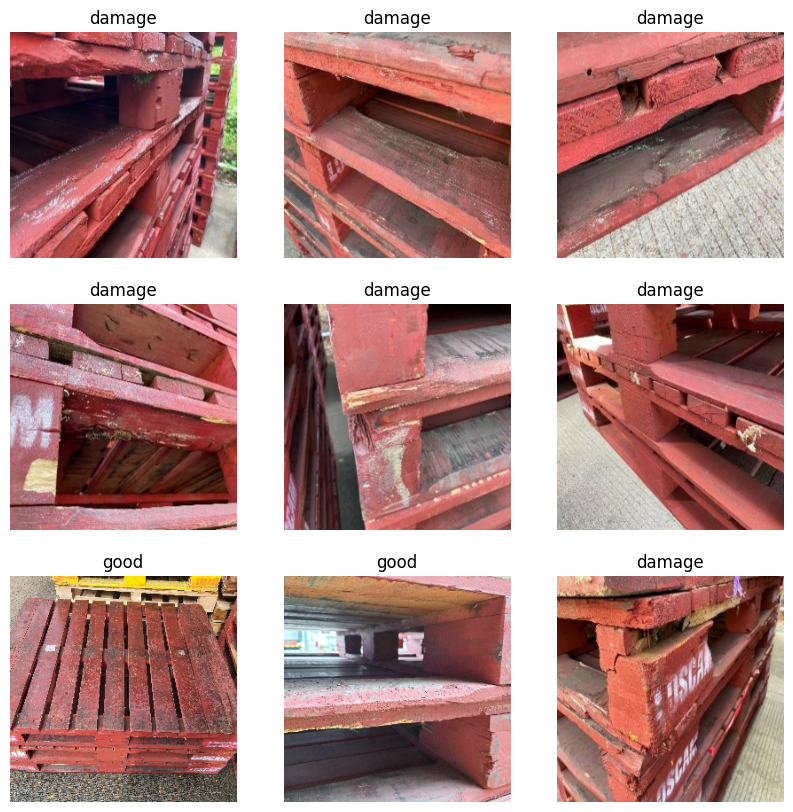

In [ ]:
def plot_random_images(images, labels, class_names, num_images=9):
    plt.figure(figsize=(10, 10))
    indices = np.random.choice(len(images), num_images, replace=False)
    for i, idx in enumerate(indices):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[idx].astype("uint8"))
        plt.title(class_names[labels[idx]])
        plt.axis("off")
    plt.show()


# Plot a sample of images
plot_random_images(x_train, y_train, train_class_names, num_images=9)

## Ramdom Crop from 256 to 224

In [ ]:
CROP_LENGTH = 224
# Apply Random Cropping

# Function to apply random cropping
def random_crop(img, random_crop_size):
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]

# Apply random cropping to the entire dataset
def apply_random_cropping(images, labels, crop_length):
    cropped_images = np.zeros((images.shape[0], crop_length, crop_length, 3))
    for i in range(images.shape[0]):
        cropped_images[i] = random_crop(images[i], (crop_length, crop_length))
    return cropped_images, labels


# Apply random cropping
x_train_cropped, y_train_cropped = apply_random_cropping(x_train, y_train, CROP_LENGTH)
x_val_cropped, y_val_cropped = apply_random_cropping(x_val, y_val, CROP_LENGTH)
x_test_cropped, y_test_cropped = apply_random_cropping(x_test, y_test, CROP_LENGTH)

# Print shapes of cropped datasets
print(f'Training data shape after cropping: {x_train_cropped.shape}')
print(f'Training labels shape: {y_train_cropped.shape}')
print(f'Validation data shape after cropping: {x_val_cropped.shape}')
print(f'Validation labels shape: {y_val_cropped.shape}')
print(f'Test data shape after cropping: {x_test_cropped.shape}')
print(f'Test labels shape: {y_test_cropped.shape}')

Training data shape after cropping: (828, 224, 224, 3)
Training labels shape: (828,)
Validation data shape after cropping: (177, 224, 224, 3)
Validation labels shape: (177,)
Test data shape after cropping: (177, 224, 224, 3)
Test labels shape: (177,)


## Rescale and Augmentation

In [ ]:
rescale = tf.keras.Sequential([
  layers.Rescaling(1./255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.5, 0.2),
  layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='constant', name='rand_trans')
])

In [ ]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # rescale all datasets.
  ds = ds.map(lambda x, y: (rescale(x), y),
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Create a tf.data.Dataset from the NumPy arrays
train_ds = tf.data.Dataset.from_tensor_slices((x_train_cropped, y_train_cropped))
val_ds = tf.data.Dataset.from_tensor_slices((x_val_cropped, y_val_cropped))
test_ds = tf.data.Dataset.from_tensor_slices((x_test_cropped, y_test_cropped))


In [ ]:
#Apply augmentation and rescale
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

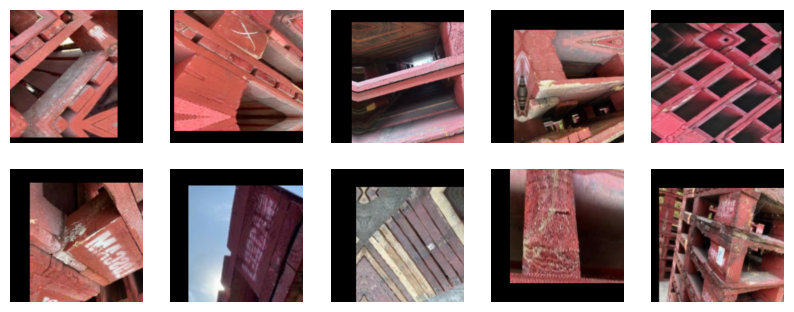

In [ ]:
# Function to plot images after applying augmentation
def plot_images(dataset, num_images):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy())
            plt.axis("off")

# Plot random images from train_ds
plot_images(train_ds, num_images=10)
plt.show()

In [ ]:
# Function to check image size in train_ds
def check_image_size(dataset):
    for images, _ in dataset.take(1):  # Take the first batch
        print(f"Training Image shape: {images.shape}")

# Check the size of the images
check_image_size(train_ds)


Training Image shape: (32, 224, 224, 3)


In [ ]:
# Function to count total number of images train_ds
def count_images(dataset):
    total_images = 0
    for images, _ in dataset:
        batch_size = images.shape[0]
        total_images += batch_size
    return total_images

# Count the total number of images
total_images = count_images(train_ds)
print(f"Total number of images in train dataset: {total_images}")

Total number of images in train dataset: 828


## Over Sampling

In [ ]:
# Function to convert dataset to NumPy arrays
def dataset_to_numpy(dataset):
    images_list = []
    labels_list = []

    for images, labels in dataset:
        images_list.append(images.numpy())
        labels_list.append(labels.numpy())

    images_array = np.concatenate(images_list, axis=0)
    labels_array = np.concatenate(labels_list, axis=0)

    return images_array, labels_array

# Convert train_ds to NumPy arrays
x_train_np, y_train_np = dataset_to_numpy(train_ds)

print("x_ train Images shape:", x_train_np.shape)
print("y_ train shape:", y_train_np.shape)

# Convert val_ds to NumPy arrays
x_val_np, y_val_np = dataset_to_numpy(val_ds)

print("x_ val Images shape:", x_val_np.shape)
print("y_ val shape:", y_val_np.shape)

# Convert test_ds to NumPy arrays
x_test_np, y_test_np = dataset_to_numpy(test_ds)

print("x_ test Images shape:", x_test_np.shape)
print("y_ test shape:", y_test_np.shape)

x_ train Images shape: (828, 224, 224, 3)
y_ train shape: (828,)
x_ val Images shape: (177, 224, 224, 3)
y_ val shape: (177,)
x_ test Images shape: (177, 224, 224, 3)
y_ test shape: (177,)


In [ ]:
# Apply RandomOverSampler to training set data
def apply_random_oversampling(images, labels):
    ros = RandomOverSampler(random_state=42)
    # Reshape images to 2D (samples, features) for the oversampler
    num_samples = images.shape[0]
    image_flattened = images.reshape(num_samples, -1)

    # Apply oversampling
    X_resampled, y_resampled = ros.fit_resample(image_flattened, labels)

    # Reshape images back to original shape
    images_resampled = X_resampled.reshape(-1, *images.shape[1:])

    return images_resampled, y_resampled

# Apply oversampling to NumPy arrays
oversampled_x_train, oversampled_y_train = apply_random_oversampling(x_train_np, y_train_np)

In [ ]:
print(oversampled_x_train.shape)

(1156, 224, 224, 3)


In [ ]:
# Summary number of data after applying over sampling
# Define class names
class_names = {
    0: 'damage',
    1: 'good',
}

# Function to count images per class and map labels to class names
def count_images_per_class(labels):
    unique_labels, counts = np.unique(labels, return_counts=True)
    label_name_counts = {class_names.get(label, str(label)): count for label, count in zip(unique_labels, counts)}
    return label_name_counts

# Count images per class in the oversampled dataset
class_counts = count_images_per_class(oversampled_y_train)

# Print class counts
print("Image counts per class after oversampling:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

Image counts per class after oversampling:
damage: 578 images
good: 578 images


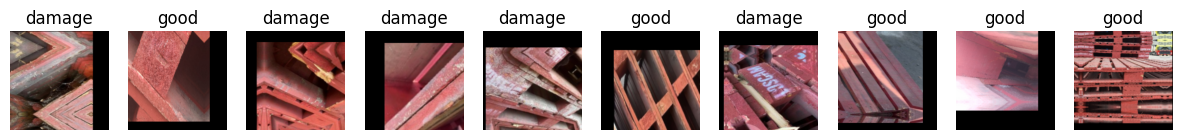

In [ ]:
# Function to plot images after over sampling
def plot_images(images, labels, class_names, num_images=10):
    plt.figure(figsize=(15, 10))

    # Randomly sample images to plot
    indices = np.random.choice(len(images), num_images, replace=False)

    for i, idx in enumerate(indices):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[idx])
        plt.title(class_names.get(labels[idx], str(labels[idx])))
        plt.axis('off')

    plt.show()

# Plot a subset of images from the oversampled dataset
plot_images(oversampled_x_train, oversampled_y_train, class_names)

## Summary data set to train the models **

In [ ]:
#1. Training Data
#  - Use oversampled_x_train, oversampled_y_train (NumPy arrays)
print(f'Training data shape: {oversampled_x_train.shape}, {oversampled_y_train.shape}')
# Count images per class in the oversampled dataset
class_counts_train = count_images_per_class(oversampled_y_train)

# Print class counts
print("Image counts per class of training set:")
for class_name, count in class_counts_train.items():
    print(f"{class_name}: {count} images")

print('\n')

#2. Validation Data
#  - Use x_val_np, y_val_np  (NumPy arrays)
print(f'Validation data shape: {x_val_np.shape}, {y_val_np.shape}')
# Count images per class
class_counts_val = count_images_per_class(y_val_np)

# Print class counts
print("Image counts per class of validation set:")
for class_name, count in class_counts_val.items():
    print(f"{class_name}: {count} images")

print('\n')

#3. Test Data
#  - Use x_test_np, y_test_np  (NumPy arrays)
print(f'Test data shape: {x_test_np.shape}, {y_test_np.shape}')
# Count images per class
class_counts_test = count_images_per_class(y_test_np)

# Print class counts
print("Image counts per class of test set:")
for class_name, count in class_counts_test.items():
    print(f"{class_name}: {count} images")



Training data shape: (1156, 224, 224, 3), (1156,)
Image counts per class of training set:
damage: 578 images
good: 578 images


Validation data shape: (177, 224, 224, 3), (177,)
Image counts per class of validation set:
damage: 123 images
good: 54 images


Test data shape: (177, 224, 224, 3), (177,)
Image counts per class of test set:
damage: 123 images
good: 54 images


# Model Development

## Load feature extractor and construct the model

In [ ]:
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

model.summary()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Model: "tf_vi_t_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit (TFViTMainLayer)        multiple                  86389248  
                                                                 
Total params: 86389248 (329.55 MB)
Trainable params: 86389248 (329.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:


batch_size = 16  # Adjust this value based on your GPU memory

# Iterate over your data in batches
for i in range(0, oversampled_x_train.shape[0], batch_size):
    batch_inputs = image_processor(oversampled_x_train[i:i+batch_size], return_tensors="tf")
    batch_outputs = model(**batch_inputs)

    # Process the outputs for this batch (e.g., extract last hidden states)
    batch_last_hidden_states = batch_outputs.last_hidden_state
    print(list(batch_last_hidden_states.shape))

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 768]
[16, 197, 

In [ ]:
# Freeze all layers in the feature extractor
model.trainable = False
model.summary()

Model: "tf_vi_t_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit (TFViTMainLayer)        multiple                  86389248  
                                                                 
Total params: 86389248 (329.55 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 86389248 (329.55 MB)
_________________________________________________________________


In [ ]:
# An input layer
img_inputs = tf.keras.layers.Input(shape=(3,224,224), name='img_inputs', dtype='float32')

# Convert KerasTensor to EagerTensor
# A lambda layer is used to perform the conversion within the Keras model
vit_features = tf.keras.layers.Lambda(lambda x: model(x).last_hidden_state)(img_inputs)

# Classifier head
cls_outputs = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs')(vit_features[:, 0, :])

# Construct the model
model2 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs])
model2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 197, 768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item (GetItem)                   │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs (Dense)                  │ (None, 2)                   │           1,538 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,538 (6.01 KB)

 Trainable params: 1,538 (6.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

## Prepare data for model

In [ ]:
# Change images from channel-last (default of Keras and TensorFlow) to channel-first (required by Huggingface's ViT)
x_train2 = np.moveaxis(oversampled_x_train, -1, 1)
x_test2 = np.moveaxis(x_test_np, -1, 1)
x_val2 = np.moveaxis(x_val_np, -1, 1)

# Inspect the dataset
print( f"x_train2: type={type(x_train2)} , dtype={x_train2.dtype} , shape={x_train2.shape} , min={x_train2.min(axis=None)} , max={x_train2.max(axis=None)}" )
print( f"x_test2: type={type(x_test2)} , dtype={x_test2.dtype} , shape={x_test2.shape} , min={x_test2.min(axis=None)} , max={x_test2.max(axis=None)}"  )

x_train2: type=<class 'numpy.ndarray'> , dtype=float32 , shape=(1156, 3, 224, 224) , min=0.0 , max=1.0
x_test2: type=<class 'numpy.ndarray'> , dtype=float32 , shape=(177, 3, 224, 224) , min=0.0 , max=1.0


In [ ]:
x_train_vit = np.array( image_processor(x_train2,do_rescale = False)['pixel_values'] )
y_train_vit = oversampled_y_train
x_test_vit = np.array( image_processor(x_test2,do_rescale = False)['pixel_values'] )
y_test_vit = y_test_np
x_val_vit = np.array( image_processor(x_val2,do_rescale = False)['pixel_values'] )
y_val_vit = y_val_np

# Inspect the dataset
print( f"x_train_vit: type={type(x_train_vit)} , dtype={x_train_vit.dtype} , shape={x_train_vit.shape} , min={x_train_vit.min(axis=None)} , max={x_train_vit.max(axis=None)}" )
print( f"y_train_vit: type={type(y_train_vit)} , dtype={y_train_vit.dtype} , shape={y_train_vit.shape} , min={min(y_train_vit)} , max={max(y_train_vit)}" )
print( f"x_test_vit: type={type(x_test_vit)} , dtype={x_test_vit.dtype} , shape={x_test_vit.shape} , min={x_test_vit.min(axis=None)} , max={x_test_vit.max(axis=None)}"  )
print( f"y_test_vit: type={type(y_test_vit)} , dtype={y_test_vit.dtype} , shape={y_test_vit.shape} , min={min(y_test_vit)} , max={max(y_test_vit)}" )
print( f"x_val_vit: type={type(x_val_vit)} , dtype={x_val_vit.dtype} , shape={x_val_vit.shape} , min={x_val_vit.min(axis=None)} , max={x_val_vit.max(axis=None)}"  )
print( f"y_val_vit: type={type(y_val_vit)} , dtype={y_val_vit.dtype} , shape={y_val_vit.shape} , min={min(y_val_vit)} , max={max(y_val_vit)}" )

x_train_vit: type=<class 'numpy.ndarray'> , dtype=float32 , shape=(1156, 3, 224, 224) , min=-1.0 , max=1.0
y_train_vit: type=<class 'numpy.ndarray'> , dtype=int32 , shape=(1156,) , min=0 , max=1
x_test_vit: type=<class 'numpy.ndarray'> , dtype=float32 , shape=(177, 3, 224, 224) , min=-1.0 , max=1.0
y_test_vit: type=<class 'numpy.ndarray'> , dtype=int32 , shape=(177,) , min=0 , max=1
x_val_vit: type=<class 'numpy.ndarray'> , dtype=float32 , shape=(177, 3, 224, 224) , min=-1.0 , max=1.0
y_val_vit: type=<class 'numpy.ndarray'> , dtype=int32 , shape=(177,) , min=0 , max=1


In [ ]:
# Change data to to one-hot encoding to match the model's output shape
from tensorflow.keras.utils import to_categorical


# Convert y_test_vit to one-hot encoding
y_test_vit_encoded = to_categorical(y_test_vit, num_classes=2)
y_train_vit_encoded = to_categorical(y_train_vit, num_classes=2)
y_val_vit_encoded = to_categorical(y_val_vit, num_classes=2)

In [ ]:
y_test_vit.shape

(177,)

In [ ]:
y_test_vit_encoded.shape

(177, 2)

In [ ]:
x_test_vit.shape

(177, 3, 224, 224)

## Fine tune the model

In [ ]:
import tensorflow as tf

# Force eager execution to avoid the error
tf.config.run_functions_eagerly(True)

In [ ]:
# Evaluate the model BEFORE finetuning
model2.evaluate(x_test_vit, y_test_vit_encoded)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - acc: 0.6303 - loss: 0.6745


[0.6675288081169128, 0.6836158037185669]

In [ ]:
import tensorflow as tf

# Disable eager execution
tf.config.run_functions_eagerly(False)

# Check GPU availability and memory usage
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Use more memory or let Tensorflow manage it
        # tf.config.set_logical_device_configuration(
        #     gpus[0],
        #     [tf.config.LogicalDeviceConfiguration(memory_limit=2048)] # Increase if needed
        # )
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Clear the session to release any held resources
tf.keras.backend.clear_session()

1 Physical GPUs, 1 Logical GPUs


In [ ]:
# Re-enable eager execution
tf.config.run_functions_eagerly(True)

##Add dense 512 & 256 to model

###Round 1

In [ ]:
# An input layer
#img_inputs = tf.keras.layers.Input(shape=(3,224,224), name='img_inputs', dtype='float32')

# Convert KerasTensor to EagerTensor
# A lambda layer is used to perform the conversion within the Keras model
#vit_features = tf.keras.layers.Lambda(lambda x: model(x).last_hidden_state)(img_inputs)

# Classifier head
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(dense_512)
cls_outputs_m4 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m4')(dense_256)

# Construct the model
model4 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m4])
model4.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 197, 768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_1 (GetItem)                 │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m4 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 525,570 (2.00 MB)

 Trainable params: 525,570 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Evaluate the model BEFORE finetuning
model4.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - acc: 0.3590 - loss: 0.7358


[0.7467081546783447, 0.3050847351551056]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history4 = model4.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 17s 471ms/step - acc: 0.7897 - loss: 0.4208 - val_acc: 0.9435 - val_loss: 0.1472
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 17s 467ms/step - acc: 0.9701 - loss: 0.0715 - val_acc: 0.8983 - val_loss: 0.2727
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 17s 467ms/step - acc: 0.9925 - loss: 0.0366 - val_acc: 0.9661 - val_loss: 0.1083
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 18s 476ms/step - acc: 1.0000 - loss: 0.0075 - val_acc: 0.9661 - val_loss: 0.0884
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 17s 473ms/step - acc: 1.0000 - loss: 0.0013 - val_acc: 0.9661 - val_loss: 0.0950
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 17s 469ms/step - acc: 1.0000 - loss: 7.4176e-04 - val_acc: 0.9661 - val_loss: 0.0924
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 17s 470ms/step - acc: 1.0000 - loss: 4.6788e-04 - val_acc: 0.9661 - val_loss: 0.0880
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 17s 469ms/step - acc: 1.0000 - loss: 3.2474e-04 - val_acc: 0.9661 - val_loss: 0.0909
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━

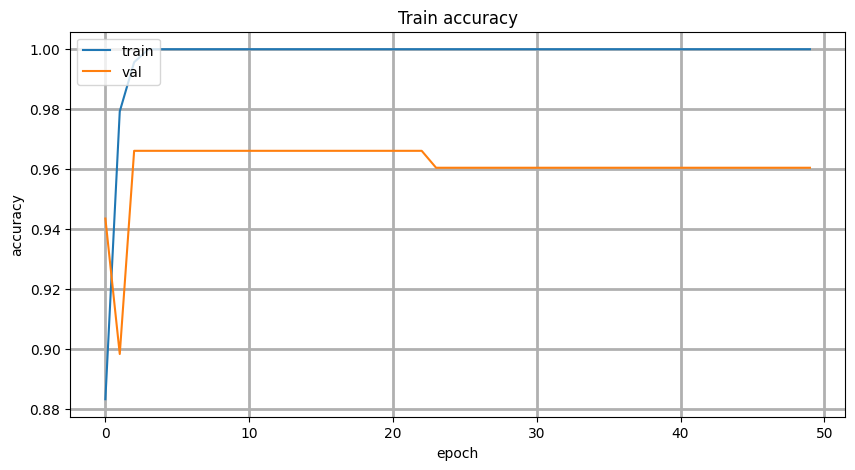

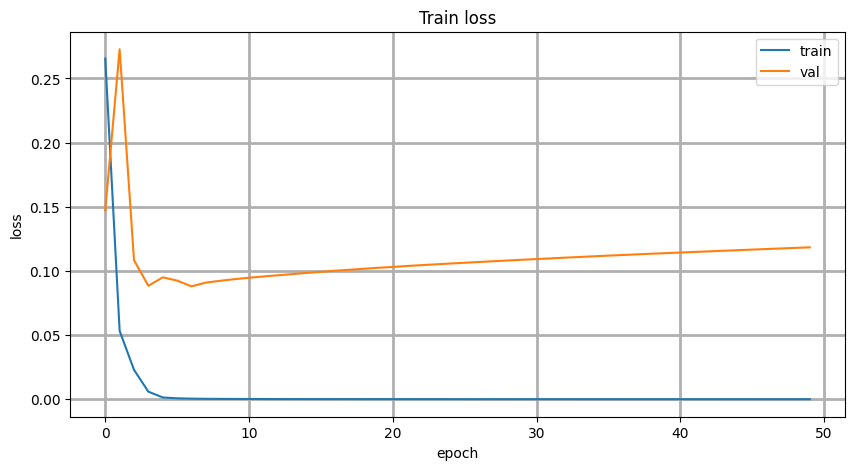

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history4.history['acc'])
plt.plot(history4.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model4.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - acc: 0.9908 - loss: 0.0284


[0.04218102619051933, 0.9830508232116699]

In [ ]:
#save model4
model4.save('/content/drive/MyDrive/DADS_Deep Learning/Final_Project/save_model/B_16_step_2.h5')

###Round 2

In [ ]:
import numpy as np
print( f"NumPy {np.__version__}\n" )
np.random.seed(123)

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )
tf.random.set_seed(123)

NumPy 1.26.4

TensorFlow 2.17.0
tf.keras.backend.image_data_format() = channels_last


In [ ]:
# An input layer
#img_inputs = tf.keras.layers.Input(shape=(3,224,224), name='img_inputs', dtype='float32')

# Convert KerasTensor to EagerTensor
# A lambda layer is used to perform the conversion within the Keras model
#vit_features = tf.keras.layers.Lambda(lambda x: model(x).last_hidden_state)(img_inputs)

# Classifier head
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(dense_512)
cls_outputs_m4 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m4')(dense_256)

# Construct the model
model4 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m4])
model4.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 197, 768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_3 (GetItem)                 │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m4 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 525,570 (2.00 MB)

 Trainable params: 525,570 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Evaluate the model BEFORE finetuning
model4.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - acc: 0.3472 - loss: 0.7184


[0.7212693095207214, 0.3163841664791107]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history4 = model4.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 675ms/step - acc: 0.8511 - loss: 0.4037 - val_acc: 0.8983 - val_loss: 0.2047
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 666ms/step - acc: 0.9856 - loss: 0.0622 - val_acc: 0.9492 - val_loss: 0.0949
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 667ms/step - acc: 1.0000 - loss: 0.0072 - val_acc: 0.9492 - val_loss: 0.0788
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 666ms/step - acc: 1.0000 - loss: 0.0033 - val_acc: 0.9774 - val_loss: 0.0618
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 665ms/step - acc: 1.0000 - loss: 0.0011 - val_acc: 0.9831 - val_loss: 0.0529
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 668ms/step - acc: 1.0000 - loss: 6.9929e-04 - val_acc: 0.9831 - val_loss: 0.0518
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 24s 661ms/step - acc: 1.0000 - loss: 4.6591e-04 - val_acc: 0.9831 - val_loss: 0.0519
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 672ms/step - acc: 1.0000 - loss: 3.3597e-04 - val_acc: 0.9831 - val_loss: 0.0524
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━

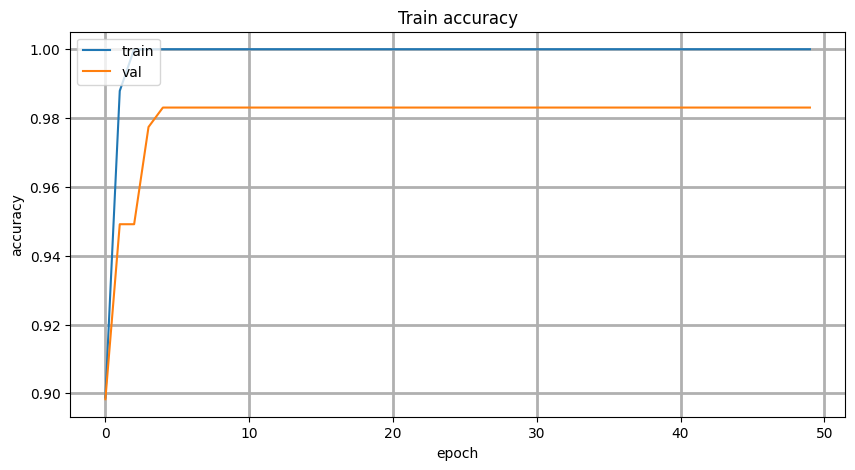

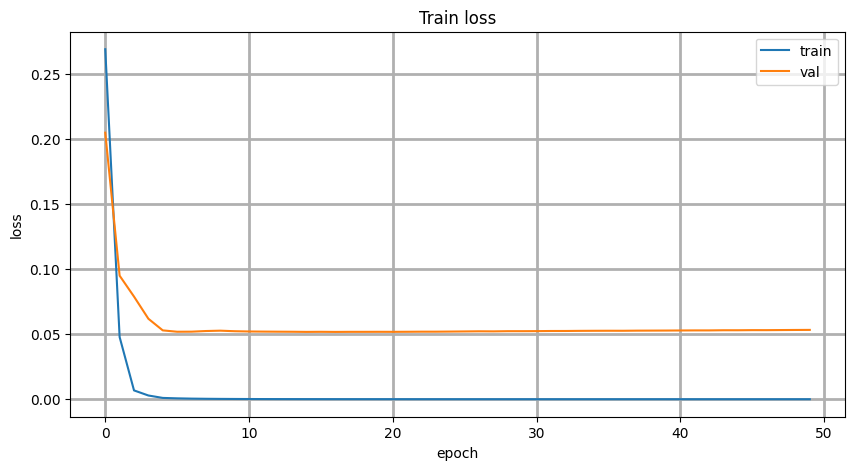

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history4.history['acc'])
plt.plot(history4.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model4.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - acc: 0.9783 - loss: 0.1097


[0.08873008191585541, 0.9830508232116699]

In [ ]:
#save model4
model4.save('/content/drive/MyDrive/DADS_Deep Learning/Final_Project/save_model/B_16_step_2_round2.h5')

###Round 3

In [ ]:
import numpy as np
print( f"NumPy {np.__version__}\n" )
np.random.seed(1234)

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )
tf.random.set_seed(1234)

NumPy 1.26.4

TensorFlow 2.17.0
tf.keras.backend.image_data_format() = channels_last


In [ ]:
# An input layer
#img_inputs = tf.keras.layers.Input(shape=(3,224,224), name='img_inputs', dtype='float32')

# Convert KerasTensor to EagerTensor
# A lambda layer is used to perform the conversion within the Keras model
#vit_features = tf.keras.layers.Lambda(lambda x: model(x).last_hidden_state)(img_inputs)

# Classifier head
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(dense_512)
cls_outputs_m4 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m4')(dense_256)

# Construct the model
model4 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m4])
model4.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 197, 768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_2 (GetItem)                 │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m4 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 525,570 (2.00 MB)

 Trainable params: 525,570 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Evaluate the model BEFORE finetuning
model4.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - acc: 0.4972 - loss: 0.6956


[0.6971811652183533, 0.4971751272678375]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history4 = model4.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 671ms/step - acc: 0.7617 - loss: 0.4381 - val_acc: 0.9322 - val_loss: 0.1778
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 662ms/step - acc: 0.9824 - loss: 0.0505 - val_acc: 0.9435 - val_loss: 0.1236
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 663ms/step - acc: 0.9937 - loss: 0.0172 - val_acc: 0.9718 - val_loss: 0.0826
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 667ms/step - acc: 1.0000 - loss: 0.0056 - val_acc: 0.9718 - val_loss: 0.0888
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 668ms/step - acc: 1.0000 - loss: 0.0014 - val_acc: 0.9774 - val_loss: 0.0703
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 668ms/step - acc: 1.0000 - loss: 0.0011 - val_acc: 0.9774 - val_loss: 0.0752
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 667ms/step - acc: 1.0000 - loss: 5.2084e-04 - val_acc: 0.9774 - val_loss: 0.0879
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 670ms/step - acc: 1.0000 - loss: 2.5868e-04 - val_acc: 0.9774 - val_loss: 0.0848
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25

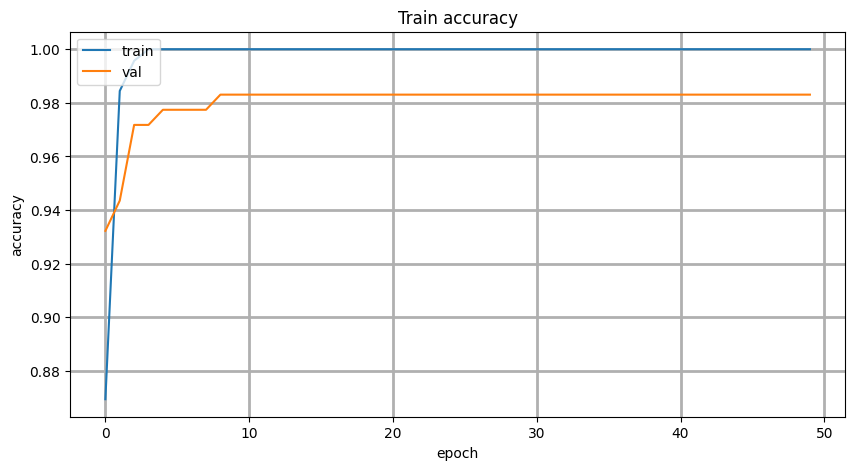

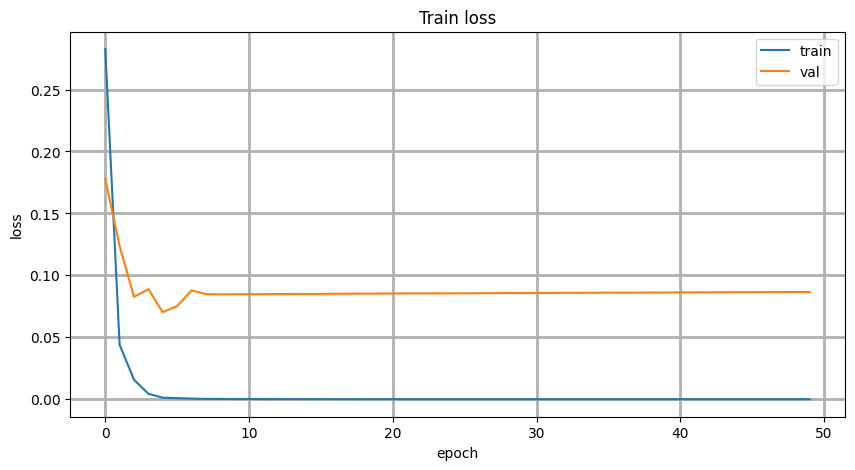

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history4.history['acc'])
plt.plot(history4.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model4.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - acc: 0.9783 - loss: 0.1031


[0.08990559726953506, 0.9830508232116699]

In [ ]:
#save model4
model4.save('/content/drive/MyDrive/DADS_Deep Learning/Final_Project/save_model/B_16_step_2_round3.h5')

##Add dense 512 & 256 with BatchNorm to model

###Round 1


In [ ]:
# Classifier head
# Add Dense layers
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
bn_512 = tf.keras.layers.BatchNormalization(name='bn_512')(dense_512)

dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(bn_512)
bn_256 = tf.keras.layers.BatchNormalization(name='bn_256')(dense_256)

cls_outputs_m5 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m5')(bn_256)

# Construct the model
model5 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m5])
model5.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 197, 768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_2 (GetItem)                 │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_512 (BatchNormalization)          │ (None, 512)                 │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_256 (BatchNormalization)          │ (None, 256)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m5 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 528,642 (2.02 MB)

 Trainable params: 527,106 (2.01 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [ ]:
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Evaluate the model BEFORE finetuning
model5.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - acc: 0.5087 - loss: 0.6978


[0.6974071264266968, 0.5254237055778503]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history5 = model5.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 511ms/step - acc: 0.8072 - loss: 0.3986 - val_acc: 0.7910 - val_loss: 0.3859
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 18s 497ms/step - acc: 0.9905 - loss: 0.0387 - val_acc: 0.8983 - val_loss: 0.3290
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 18s 498ms/step - acc: 1.0000 - loss: 0.0055 - val_acc: 0.9266 - val_loss: 0.2806
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 18s 496ms/step - acc: 1.0000 - loss: 0.0021 - val_acc: 0.9040 - val_loss: 0.2456
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 18s 496ms/step - acc: 1.0000 - loss: 0.0014 - val_acc: 0.9096 - val_loss: 0.2159
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 18s 494ms/step - acc: 1.0000 - loss: 0.0011 - val_acc: 0.9209 - val_loss: 0.1932
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 18s 495ms/step - acc: 1.0000 - loss: 8.6749e-04 - val_acc: 0.9209 - val_loss: 0.1764
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 18s 495ms/step - acc: 1.0000 - loss: 7.1714e-04 - val_acc: 0.9209 - val_loss: 0.1648
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 18

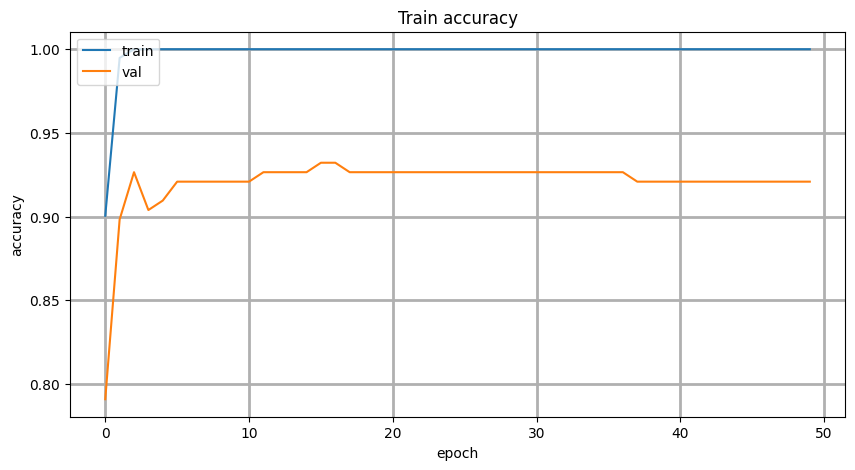

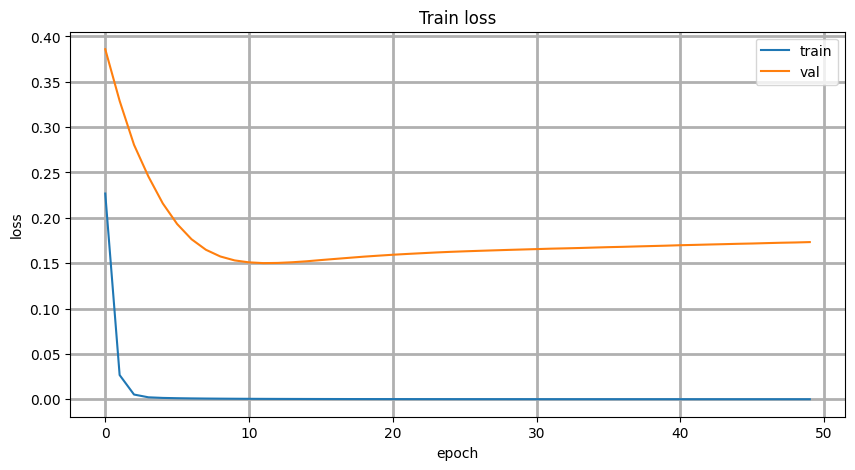

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history5.history['acc'])
plt.plot(history5.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model5.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - acc: 0.9732 - loss: 0.0472


[0.047627318650484085, 0.9774011373519897]

In [ ]:
#save model5
model5.save('/content/drive/MyDrive/DADS_Deep Learning/Final_Project/save_model/B_16_step_3.h5')

###Round 2

In [ ]:
# Classifier head
# Add Dense layers
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
bn_512 = tf.keras.layers.BatchNormalization(name='bn_512')(dense_512)

dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(bn_512)
bn_256 = tf.keras.layers.BatchNormalization(name='bn_256')(dense_256)

cls_outputs_m5 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m5')(bn_256)

# Construct the model
model5 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m5])
model5.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 197, 768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_6 (GetItem)                 │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_512 (BatchNormalization)          │ (None, 512)                 │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_256 (BatchNormalization)          │ (None, 256)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m5 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 528,642 (2.02 MB)

 Trainable params: 527,106 (2.01 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [ ]:
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Evaluate the model BEFORE finetuning
model5.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - acc: 0.3502 - loss: 0.7158


[0.7156850099563599, 0.3446327745914459]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history5 = model5.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 708ms/step - acc: 0.8211 - loss: 0.4166 - val_acc: 0.8927 - val_loss: 0.4214
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 700ms/step - acc: 0.9893 - loss: 0.0406 - val_acc: 0.9040 - val_loss: 0.3386
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 698ms/step - acc: 0.9988 - loss: 0.0143 - val_acc: 0.9379 - val_loss: 0.2853
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 701ms/step - acc: 1.0000 - loss: 0.0065 - val_acc: 0.9266 - val_loss: 0.2552
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 705ms/step - acc: 1.0000 - loss: 0.0027 - val_acc: 0.9435 - val_loss: 0.2293
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 709ms/step - acc: 1.0000 - loss: 0.0017 - val_acc: 0.9435 - val_loss: 0.2107
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 708ms/step - acc: 1.0000 - loss: 0.0013 - val_acc: 0.9435 - val_loss: 0.2015
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 702ms/step - acc: 1.0000 - loss: 0.0011 - val_acc: 0.9379 - val_loss: 0.1990
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 713ms/

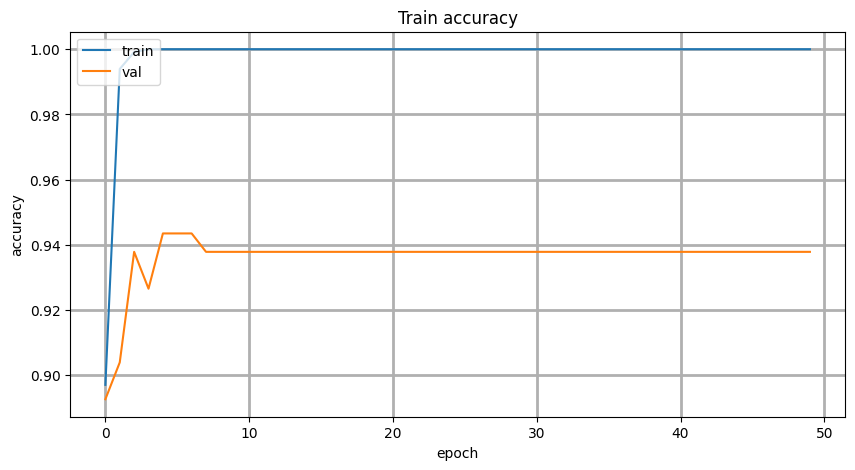

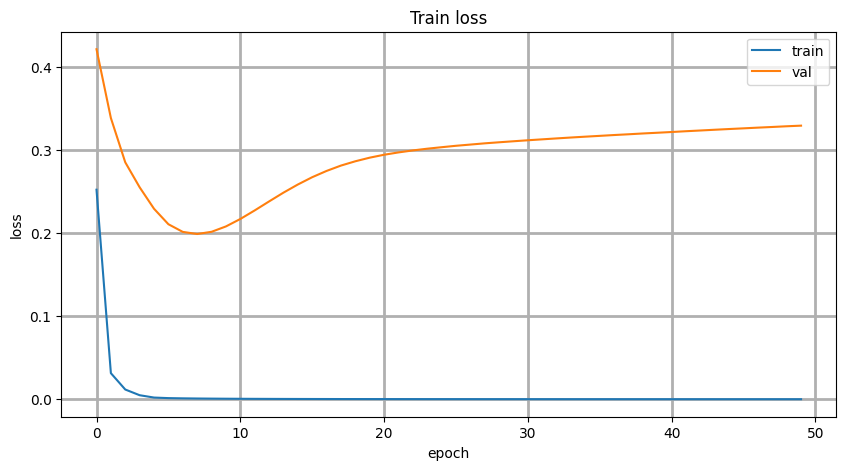

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history5.history['acc'])
plt.plot(history5.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model5.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - acc: 0.9716 - loss: 0.1769


[0.1560070812702179, 0.9717513918876648]

In [ ]:
#save model5
model5.save('/content/drive/MyDrive/DADS_Deep Learning/Final_Project/save_model/B_16_step_3_round2.h5')

###Round 3

In [ ]:
# Classifier head
# Add Dense layers
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
bn_512 = tf.keras.layers.BatchNormalization(name='bn_512')(dense_512)

dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(bn_512)
bn_256 = tf.keras.layers.BatchNormalization(name='bn_256')(dense_256)

cls_outputs_m5 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m5')(bn_256)

# Construct the model
model5 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m5])
model5.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 197, 768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_7 (GetItem)                 │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_512 (BatchNormalization)          │ (None, 512)                 │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_256 (BatchNormalization)          │ (None, 256)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m5 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 528,642 (2.02 MB)

 Trainable params: 527,106 (2.01 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [ ]:
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Evaluate the model BEFORE finetuning
model5.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - acc: 0.7135 - loss: 0.6707


[0.6689406037330627, 0.7231638431549072]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history5 = model5.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 27s 718ms/step - acc: 0.8208 - loss: 0.4200 - val_acc: 0.8983 - val_loss: 0.4502
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 698ms/step - acc: 0.9904 - loss: 0.0439 - val_acc: 0.9153 - val_loss: 0.3502
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 702ms/step - acc: 1.0000 - loss: 0.0126 - val_acc: 0.9153 - val_loss: 0.2868
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 696ms/step - acc: 1.0000 - loss: 0.0053 - val_acc: 0.9266 - val_loss: 0.2590
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 701ms/step - acc: 1.0000 - loss: 0.0023 - val_acc: 0.9266 - val_loss: 0.2289
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 704ms/step - acc: 1.0000 - loss: 0.0016 - val_acc: 0.9266 - val_loss: 0.2092
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 697ms/step - acc: 1.0000 - loss: 0.0012 - val_acc: 0.9266 - val_loss: 0.1937
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 704ms/step - acc: 1.0000 - loss: 0.0010 - val_acc: 0.9266 - val_loss: 0.1834
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 700ms/

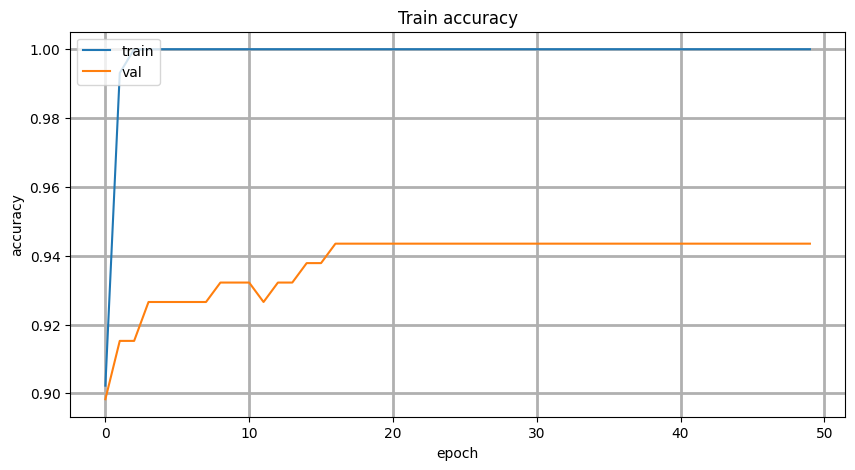

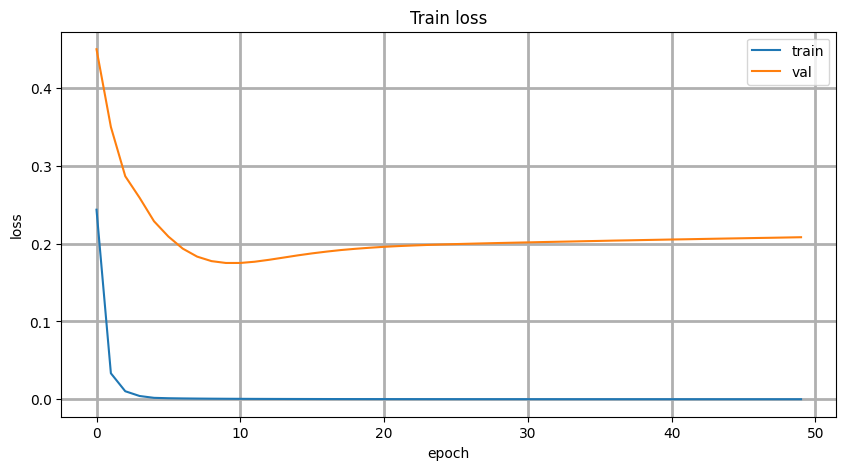

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history5.history['acc'])
plt.plot(history5.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model5.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - acc: 0.9783 - loss: 0.1128


[0.0743868425488472, 0.9830508232116699]

In [ ]:
#save model5
model5.save('/content/drive/MyDrive/DADS_Deep Learning/Final_Project/save_model/B_16_step_3_round3.h5')

##Add dense 512 & 256 with dropout 0.5 to model

###Round 1

In [ ]:
# Classifier head
# Add Dense layers
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
#bn_512 = tf.keras.layers.BatchNormalization(name='bn_512')(dense_512)
dropout1 = tf.keras.layers.Dropout(0.5)(dense_512)

dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(dropout1)
#bn_256 = tf.keras.layers.BatchNormalization(name='bn_256')(dense_256)
dropout2 = tf.keras.layers.Dropout(0.5)(dense_256)

cls_outputs_m6 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m6')(dropout2)

# Construct the model
model6 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m6])
model6.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 197, 768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_6 (GetItem)                 │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m6 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 525,570 (2.00 MB)

 Trainable params: 525,570 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
#import tensorflow as tf

# Force eager execution to avoid the error
#tf.config.run_functions_eagerly(True)

# Evaluate the model BEFORE finetuning
model6.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 654ms/step - acc: 0.7143 - loss: 0.6730


[0.6742680668830872, 0.7118644118309021]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history6 = model6.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 244ms/step - acc: 0.7381 - loss: 0.5358 - val_acc: 0.7853 - val_loss: 0.4947
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - acc: 0.9485 - loss: 0.1525 - val_acc: 0.8814 - val_loss: 0.2499
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - acc: 0.9803 - loss: 0.0571 - val_acc: 0.9040 - val_loss: 0.2048
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - acc: 0.9839 - loss: 0.0457 - val_acc: 0.9040 - val_loss: 0.2360
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - acc: 0.9974 - loss: 0.0176 - val_acc: 0.8983 - val_loss: 0.2560
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - acc: 0.9995 - loss: 0.0114 - val_acc: 0.9153 - val_loss: 0.2081
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - acc: 1.0000 - loss: 0.0052 - val_acc: 0.9266 - val_loss: 0.2167
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - acc: 0.9962 - loss: 0.0110 - val_acc: 0.9322 - val_loss: 0.1894
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - a

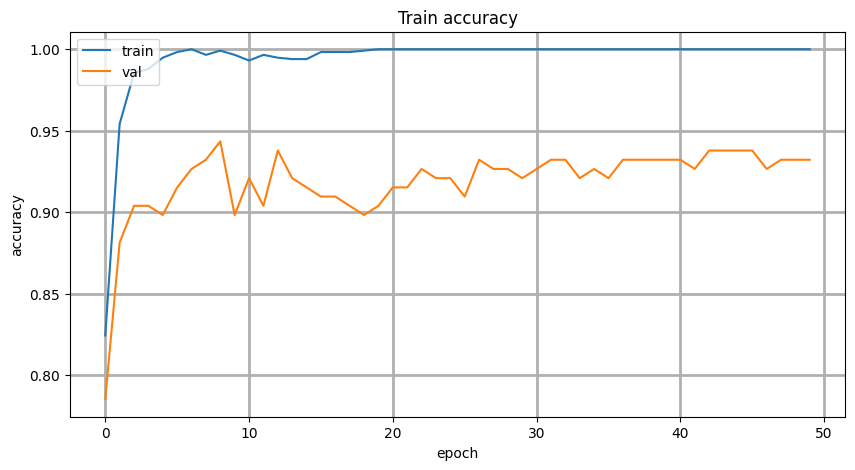

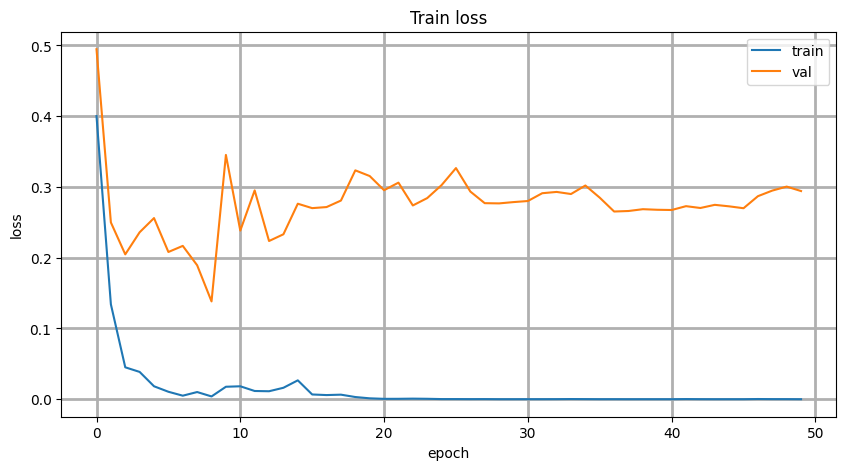

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history6.history['acc'])
plt.plot(history6.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model6.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - acc: 0.9670 - loss: 0.1358


[0.15243744850158691, 0.9661017060279846]

In [ ]:
#save model6
model6.save('/content/drive/MyDrive/DADS_Deep Learning/Final_Project/save_model/deit_step_4_1.h5')

###Round 2

In [ ]:
# Classifier head
# Add Dense layers
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
#bn_512 = tf.keras.layers.BatchNormalization(name='bn_512')(dense_512)
dropout1 = tf.keras.layers.Dropout(0.5)(dense_512)

dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(dropout1)
#bn_256 = tf.keras.layers.BatchNormalization(name='bn_256')(dense_256)
dropout2 = tf.keras.layers.Dropout(0.5)(dense_256)

cls_outputs_m6 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m6')(dropout2)

# Construct the model
model6 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m6])
model6.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 197, 768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_7 (GetItem)                 │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m6 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 525,570 (2.00 MB)

 Trainable params: 525,570 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
#import tensorflow as tf

# Force eager execution to avoid the error
#tf.config.run_functions_eagerly(True)

# Evaluate the model BEFORE finetuning
model6.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 652ms/step - acc: 0.4197 - loss: 0.7048


[0.704206645488739, 0.4237288236618042]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history6 = model6.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 229ms/step - acc: 0.7236 - loss: 0.5470 - val_acc: 0.7797 - val_loss: 0.5106
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - acc: 0.9404 - loss: 0.1615 - val_acc: 0.8192 - val_loss: 0.4057
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - acc: 0.9833 - loss: 0.0601 - val_acc: 0.9153 - val_loss: 0.1920
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - acc: 0.9850 - loss: 0.0458 - val_acc: 0.8757 - val_loss: 0.3110
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - acc: 0.9941 - loss: 0.0244 - val_acc: 0.9096 - val_loss: 0.1998
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - acc: 0.9967 - loss: 0.0117 - val_acc: 0.9266 - val_loss: 0.2153
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - acc: 0.9975 - loss: 0.0146 - val_acc: 0.8983 - val_loss: 0.2968
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - acc: 1.0000 - loss: 0.0043 - val_acc: 0.9040 - val_loss: 0.3109
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - a

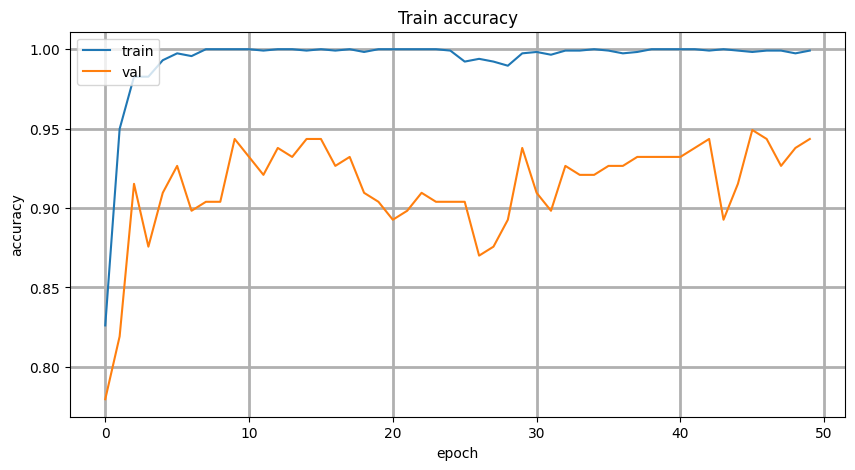

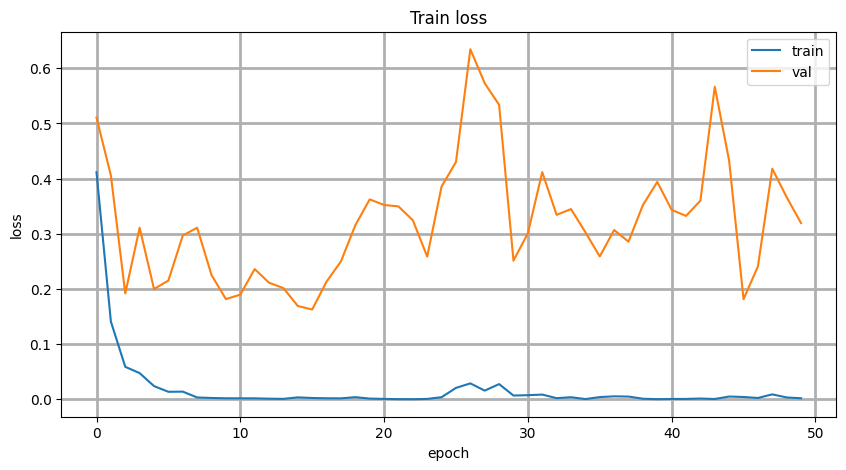

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history6.history['acc'])
plt.plot(history6.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model6.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - acc: 0.9484 - loss: 0.2442


[0.21728700399398804, 0.9604519605636597]

In [ ]:
#save model6
model6.save('/content/drive/MyDrive/DADS_Deep Learning/Final_Project/save_model/deit_step_4_1.h5')

###Round 3

In [ ]:
# Classifier head
# Add Dense layers
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
#bn_512 = tf.keras.layers.BatchNormalization(name='bn_512')(dense_512)
dropout1 = tf.keras.layers.Dropout(0.5)(dense_512)

dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(dropout1)
#bn_256 = tf.keras.layers.BatchNormalization(name='bn_256')(dense_256)
dropout2 = tf.keras.layers.Dropout(0.5)(dense_256)

cls_outputs_m6 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m6')(dropout2)

# Construct the model
model6 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m6])
model6.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 197, 768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_8 (GetItem)                 │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m6 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 525,570 (2.00 MB)

 Trainable params: 525,570 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
#import tensorflow as tf

# Force eager execution to avoid the error
#tf.config.run_functions_eagerly(True)

# Evaluate the model BEFORE finetuning
model6.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 659ms/step - acc: 0.5017 - loss: 0.6943


[0.6913943290710449, 0.5310734510421753]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history6 = model6.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 233ms/step - acc: 0.7595 - loss: 0.5265 - val_acc: 0.8588 - val_loss: 0.3253
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - acc: 0.9406 - loss: 0.1610 - val_acc: 0.8531 - val_loss: 0.2750
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - acc: 0.9795 - loss: 0.0615 - val_acc: 0.9379 - val_loss: 0.1414
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - acc: 0.9928 - loss: 0.0251 - val_acc: 0.9096 - val_loss: 0.1896
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - acc: 0.9937 - loss: 0.0205 - val_acc: 0.8588 - val_loss: 0.3986
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - acc: 0.9929 - loss: 0.0206 - val_acc: 0.9435 - val_loss: 0.1676
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - acc: 0.9996 - loss: 0.0070 - val_acc: 0.9266 - val_loss: 0.1862
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - acc: 0.9984 - loss: 0.0067 - val_acc: 0.9322 - val_loss: 0.1649
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - a

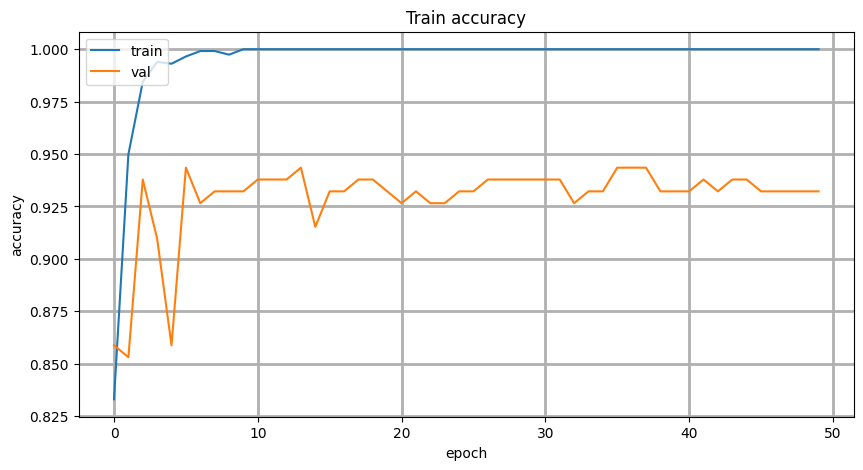

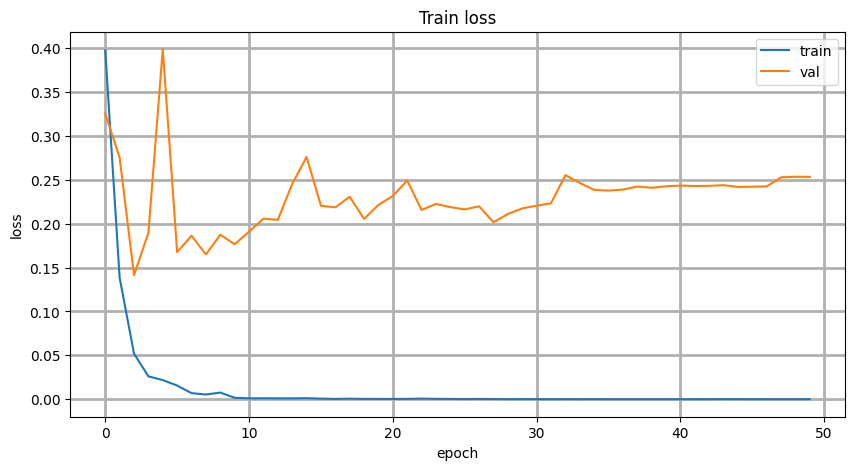

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history6.history['acc'])
plt.plot(history6.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model6.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - acc: 0.9593 - loss: 0.1150


[0.10851707309484482, 0.9717513918876648]

In [ ]:
#save model6
model6.save('/content/drive/MyDrive/DADS_Deep Learning/Final_Project/save_model/deit_step_4_1.h5')

##Add dense 512 & 256 with dropout 0.25 to model

###Round 1


In [ ]:
import numpy as np
print( f"NumPy {np.__version__}\n" )
np.random.seed(1234)

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )
tf.random.set_seed(1234)

NumPy 1.26.4

TensorFlow 2.17.0
tf.keras.backend.image_data_format() = channels_last


In [ ]:
# Classifier head
# Add Dense layers
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
#bn_512 = tf.keras.layers.BatchNormalization(name='bn_512')(dense_512)
dropout3 = tf.keras.layers.Dropout(0.25)(dense_512)

dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(dropout3)
#bn_256 = tf.keras.layers.BatchNormalization(name='bn_256')(dense_256)
dropout4 = tf.keras.layers.Dropout(0.25)(dense_256)

cls_outputs_m7 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m7')(dropout4)

# Construct the model
model7 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m7])
model7.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 197, 768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item (GetItem)                   │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m7 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 525,570 (2.00 MB)

 Trainable params: 525,570 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Evaluate the model BEFORE finetuning
model7.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - acc: 0.4431 - loss: 0.7036


[0.7063189148902893, 0.38983049988746643]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history7 = model7.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 30s 683ms/step - acc: 0.7493 - loss: 0.4696 - val_acc: 0.9322 - val_loss: 0.1499
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 671ms/step - acc: 0.9709 - loss: 0.0852 - val_acc: 0.9492 - val_loss: 0.1227
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 670ms/step - acc: 0.9925 - loss: 0.0297 - val_acc: 0.9774 - val_loss: 0.0636
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 667ms/step - acc: 0.9885 - loss: 0.0207 - val_acc: 0.9548 - val_loss: 0.1324
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 671ms/step - acc: 1.0000 - loss: 0.0056 - val_acc: 0.9492 - val_loss: 0.1202
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 668ms/step - acc: 0.9990 - loss: 0.0033 - val_acc: 0.9492 - val_loss: 0.1304
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 668ms/step - acc: 1.0000 - loss: 0.0013 - val_acc: 0.9435 - val_loss: 0.1398
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 669ms/step - acc: 1.0000 - loss: 9.9474e-04 - val_acc: 0.9435 - val_loss: 0.1456
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 66

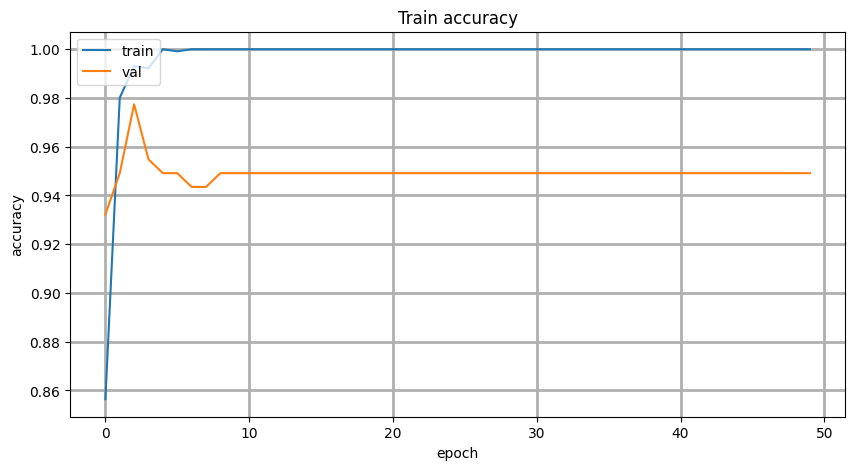

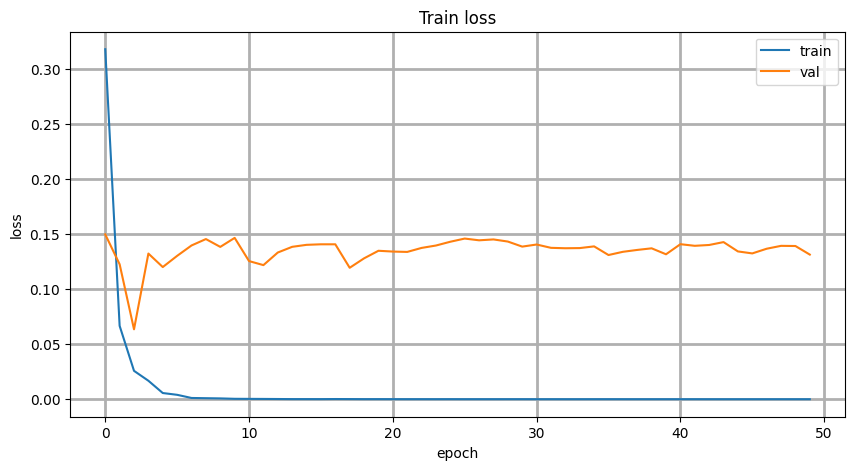

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history7.history['acc'])
plt.plot(history7.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model7.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - acc: 0.9908 - loss: 0.0507


[0.0687422901391983, 0.9830508232116699]

In [ ]:
#save model7
model7.save('/content/drive/MyDrive/DADS_Deep Learning/Final_Project/save_model/B_16_step_4_2.h5')

###Round 2

In [ ]:
# Classifier head
# Add Dense layers
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
#bn_512 = tf.keras.layers.BatchNormalization(name='bn_512')(dense_512)
dropout3 = tf.keras.layers.Dropout(0.25)(dense_512)

dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(dropout3)
#bn_256 = tf.keras.layers.BatchNormalization(name='bn_256')(dense_256)
dropout4 = tf.keras.layers.Dropout(0.25)(dense_256)

cls_outputs_m7 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m7')(dropout4)

# Construct the model
model7 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m7])
model7.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 197, 768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_2 (GetItem)                 │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m7 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 525,570 (2.00 MB)

 Trainable params: 525,570 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Evaluate the model BEFORE finetuning
model7.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 636ms/step - acc: 0.6312 - loss: 0.6851


[0.6820835471153259, 0.6666666865348816]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history7 = model7.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 240ms/step - acc: 0.7657 - loss: 0.4727 - val_acc: 0.8927 - val_loss: 0.1810
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - acc: 0.9663 - loss: 0.0913 - val_acc: 0.8983 - val_loss: 0.1993
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - acc: 0.9920 - loss: 0.0282 - val_acc: 0.8305 - val_loss: 0.5208
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - acc: 0.9887 - loss: 0.0363 - val_acc: 0.9040 - val_loss: 0.3205
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - acc: 0.9952 - loss: 0.0130 - val_acc: 0.9548 - val_loss: 0.1299
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - acc: 1.0000 - loss: 0.0021 - val_acc: 0.9548 - val_loss: 0.1447
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - acc: 1.0000 - loss: 0.0011 - val_acc: 0.9492 - val_loss: 0.1478
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - acc: 1.0000 - loss: 6.5114e-04 - val_acc: 0.9435 - val_loss: 0.1511
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step

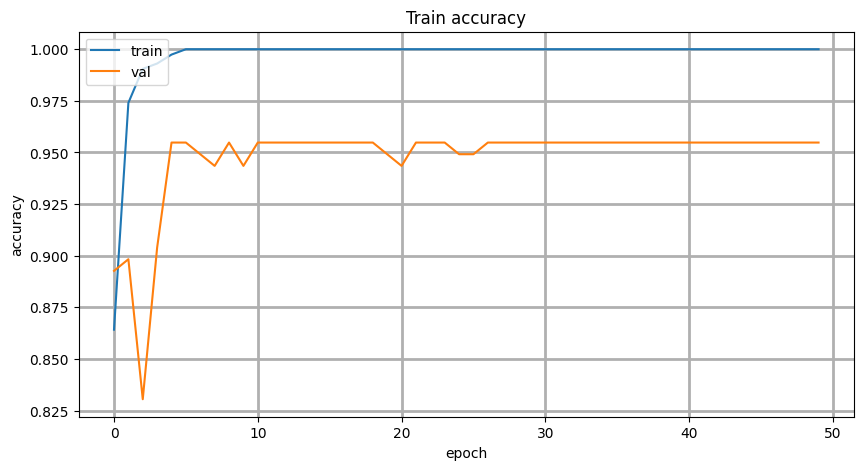

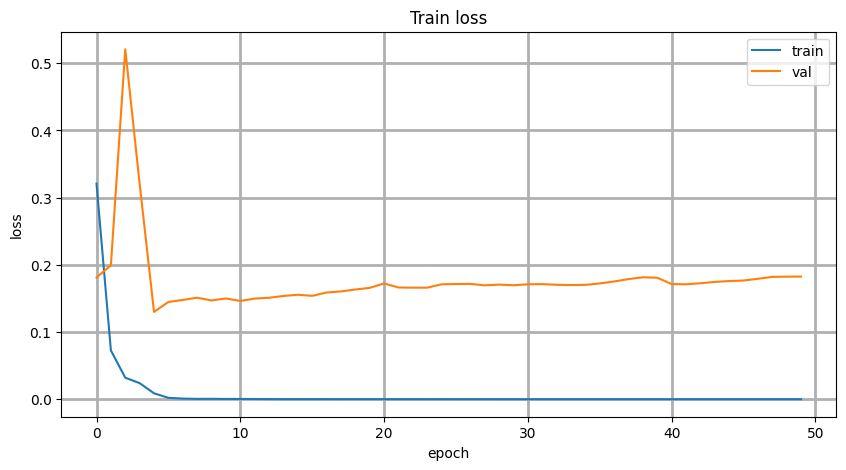

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history7.history['acc'])
plt.plot(history7.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model7.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - acc: 0.9968 - loss: 0.0129


[0.035126443952322006, 0.9887005686759949]

In [ ]:
#save model7
model7.save('/content/drive/MyDrive/DADS_Deep Learning/Final_Project/save_model/B_16_step_4_2.h5')

###Round 3


In [ ]:
import numpy as np
print( f"NumPy {np.__version__}\n" )
np.random.seed(1234)

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )
tf.random.set_seed(1234)

NumPy 1.26.4

TensorFlow 2.17.0
tf.keras.backend.image_data_format() = channels_last


In [ ]:
# Classifier head
# Add Dense layers
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
#bn_512 = tf.keras.layers.BatchNormalization(name='bn_512')(dense_512)
dropout3 = tf.keras.layers.Dropout(0.25)(dense_512)

dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(dropout3)
#bn_256 = tf.keras.layers.BatchNormalization(name='bn_256')(dense_256)
dropout4 = tf.keras.layers.Dropout(0.25)(dense_256)

cls_outputs_m7 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m7')(dropout4)

# Construct the model
model7 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m7])
model7.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 197, 768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item (GetItem)                   │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m7 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 525,570 (2.00 MB)

 Trainable params: 525,570 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Evaluate the model BEFORE finetuning
model7.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - acc: 0.4431 - loss: 0.7036


[0.7063189148902893, 0.38983049988746643]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history7 = model7.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 30s 683ms/step - acc: 0.7493 - loss: 0.4696 - val_acc: 0.9322 - val_loss: 0.1499
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 671ms/step - acc: 0.9709 - loss: 0.0852 - val_acc: 0.9492 - val_loss: 0.1227
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 670ms/step - acc: 0.9925 - loss: 0.0297 - val_acc: 0.9774 - val_loss: 0.0636
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 667ms/step - acc: 0.9885 - loss: 0.0207 - val_acc: 0.9548 - val_loss: 0.1324
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 671ms/step - acc: 1.0000 - loss: 0.0056 - val_acc: 0.9492 - val_loss: 0.1202
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 668ms/step - acc: 0.9990 - loss: 0.0033 - val_acc: 0.9492 - val_loss: 0.1304
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 668ms/step - acc: 1.0000 - loss: 0.0013 - val_acc: 0.9435 - val_loss: 0.1398
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 669ms/step - acc: 1.0000 - loss: 9.9474e-04 - val_acc: 0.9435 - val_loss: 0.1456
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 66

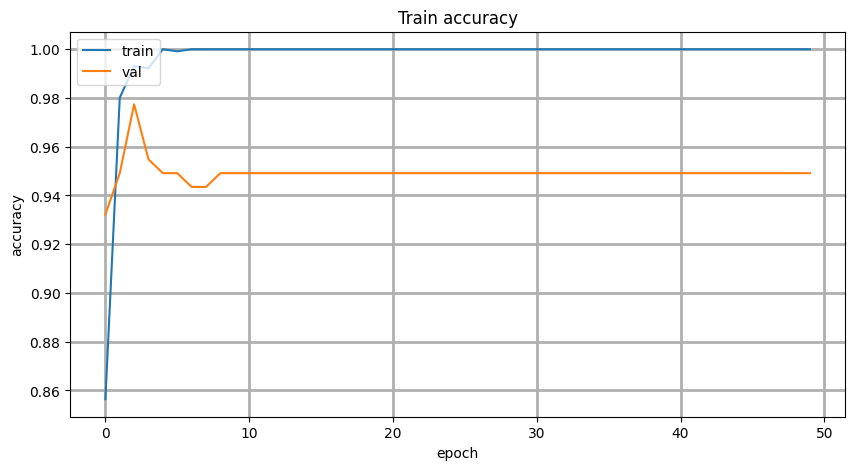

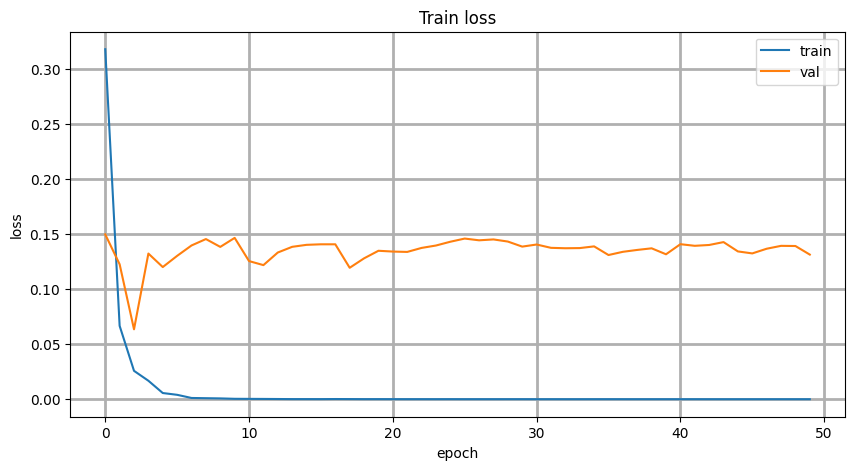

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history7.history['acc'])
plt.plot(history7.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model7.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - acc: 0.9908 - loss: 0.0507


[0.0687422901391983, 0.9830508232116699]

In [ ]:
#save model7
model7.save('/content/drive/MyDrive/DADS_Deep Learning/Final_Project/save_model/B_16_step_4_2.h5')

##Add dense 512 & 256 with dropout 0.25 with BatchNorm to model

###Round 1

In [ ]:
# Classifier head
# Add Dense layers
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
bn_512 = tf.keras.layers.BatchNormalization(name='bn_512')(dense_512)
dropout5 = tf.keras.layers.Dropout(0.25)(bn_512)

dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(dropout5)
bn_256 = tf.keras.layers.BatchNormalization(name='bn_256')(dense_256)
dropout6 = tf.keras.layers.Dropout(0.25)(bn_256)

cls_outputs_m8 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m8')(dropout6)

# Construct the model
model8 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m8])
model8.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 197, 768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item (GetItem)                   │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_512 (BatchNormalization)          │ (None, 512)                 │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_256 (BatchNormalization)          │ (None, 256)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m8 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 528,642 (2.02 MB)

 Trainable params: 527,106 (2.01 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [ ]:
model8.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Evaluate the model BEFORE finetuning
model8.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - acc: 0.4587 - loss: 0.6953


[0.695347785949707, 0.46327683329582214]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history8 = model8.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 34s 389ms/step - acc: 0.8038 - loss: 0.4307 - val_acc: 0.8305 - val_loss: 0.4068
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - acc: 0.9824 - loss: 0.0542 - val_acc: 0.8531 - val_loss: 0.3332
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - acc: 1.0000 - loss: 0.0133 - val_acc: 0.8983 - val_loss: 0.2909
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - acc: 1.0000 - loss: 0.0066 - val_acc: 0.9266 - val_loss: 0.2458
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - acc: 1.0000 - loss: 0.0035 - val_acc: 0.9266 - val_loss: 0.2189
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - acc: 1.0000 - loss: 0.0029 - val_acc: 0.9266 - val_loss: 0.1917
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - acc: 1.0000 - loss: 0.0019 - val_acc: 0.9266 - val_loss: 0.1788
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - acc: 1.0000 - loss: 0.0015 - val_acc: 0.9209 - val_loss: 0.1690
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - a

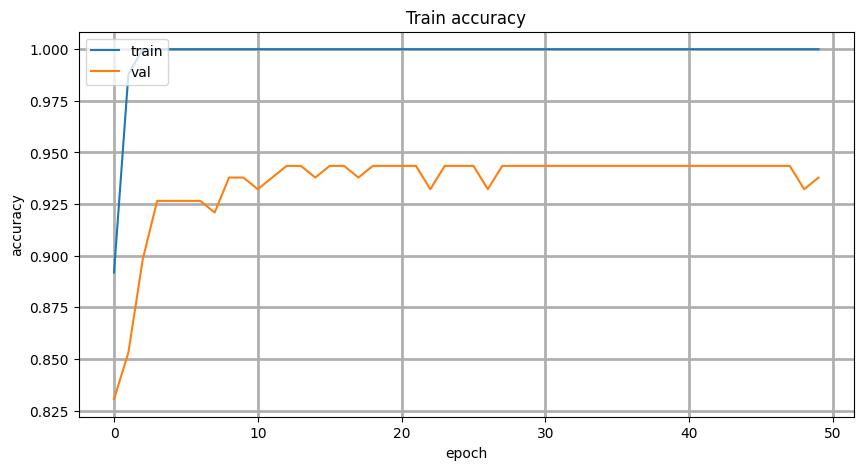

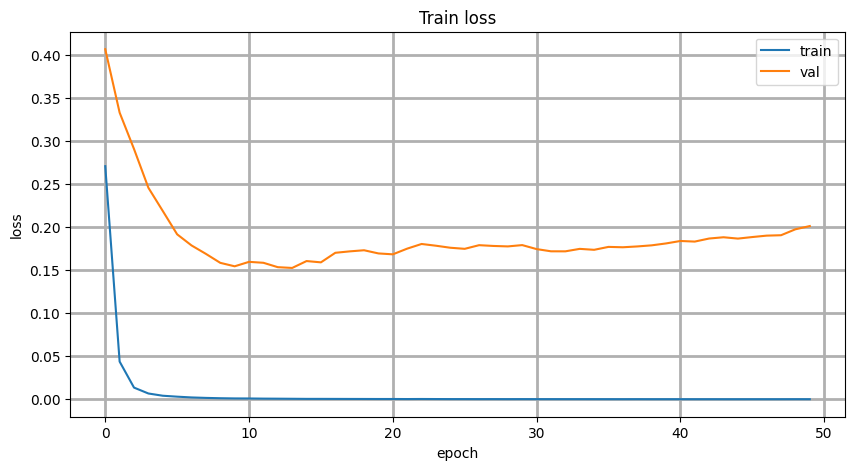

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history8.history['acc'])
plt.plot(history8.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history8.history['loss'])
plt.plot(history8.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model8.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - acc: 0.9910 - loss: 0.0225


[0.031295906752347946, 0.9887005686759949]

In [ ]:
#save model8
model8.save('/content/drive/MyDrive/Deeplearning/save_model/B/16_step_5Best.h5')

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       123
           1       0.98      0.96      0.97        54

    accuracy                           0.98       177
   macro avg       0.98      0.98      0.98       177
weighted avg       0.98      0.98      0.98       177



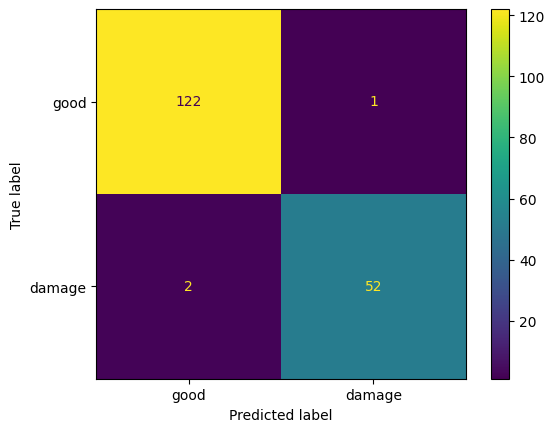

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

#y_pred = model.predict(x_test.reshape(-1, 784))
y_pred = model8.predict(x_test_vit)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_test_vit_encoded.argmax(axis=1)

# Confusion Matrix - rename variable to avoid overwriting the function
conf_matrix_result = confusion_matrix(y_true, y_pred_classes)
#print("Confusion Matrix:\n", conf_matrix_result)

# Classification Report
class_report = classification_report(y_true, y_pred_classes)
print("Classification Report:\n", class_report)

# Use the result of the confusion_matrix call, not the function itself
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix_result, display_labels = ["good","damage"])

cm_display.plot()
plt.show()

###Round 2

In [ ]:
import numpy as np
print( f"NumPy {np.__version__}\n" )
np.random.seed(123)

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )
tf.random.set_seed(123)


NumPy 1.26.4

TensorFlow 2.17.0
tf.keras.backend.image_data_format() = channels_last


In [ ]:
# Classifier head
# Add Dense layers
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
bn_512 = tf.keras.layers.BatchNormalization(name='bn_512')(dense_512)
dropout5 = tf.keras.layers.Dropout(0.25)(bn_512)

dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(dropout5)
bn_256 = tf.keras.layers.BatchNormalization(name='bn_256')(dense_256)
dropout6 = tf.keras.layers.Dropout(0.25)(bn_256)

cls_outputs_m9 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m9')(dropout6)

# Construct the model
model9 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m9])
model9.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 197, 768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_2 (GetItem)                 │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_512 (BatchNormalization)          │ (None, 512)                 │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_256 (BatchNormalization)          │ (None, 256)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m9 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 528,642 (2.02 MB)

 Trainable params: 527,106 (2.01 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [ ]:
model9.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Evaluate the model BEFORE finetuning
model9.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - acc: 0.6393 - loss: 0.6809


[0.6740762591362, 0.6892655491828918]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history9 = model9.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 709ms/step - acc: 0.8064 - loss: 0.4334 - val_acc: 0.8588 - val_loss: 0.3626
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 705ms/step - acc: 0.9960 - loss: 0.0404 - val_acc: 0.9040 - val_loss: 0.2981
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 27s 733ms/step - acc: 0.9958 - loss: 0.0173 - val_acc: 0.9209 - val_loss: 0.2633
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 711ms/step - acc: 1.0000 - loss: 0.0077 - val_acc: 0.9266 - val_loss: 0.2199
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 712ms/step - acc: 1.0000 - loss: 0.0037 - val_acc: 0.9322 - val_loss: 0.1925
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 711ms/step - acc: 1.0000 - loss: 0.0026 - val_acc: 0.9492 - val_loss: 0.1706
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 710ms/step - acc: 1.0000 - loss: 0.0018 - val_acc: 0.9322 - val_loss: 0.1565
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 711ms/step - acc: 1.0000 - loss: 0.0014 - val_acc: 0.9322 - val_loss: 0.1422
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 712ms/

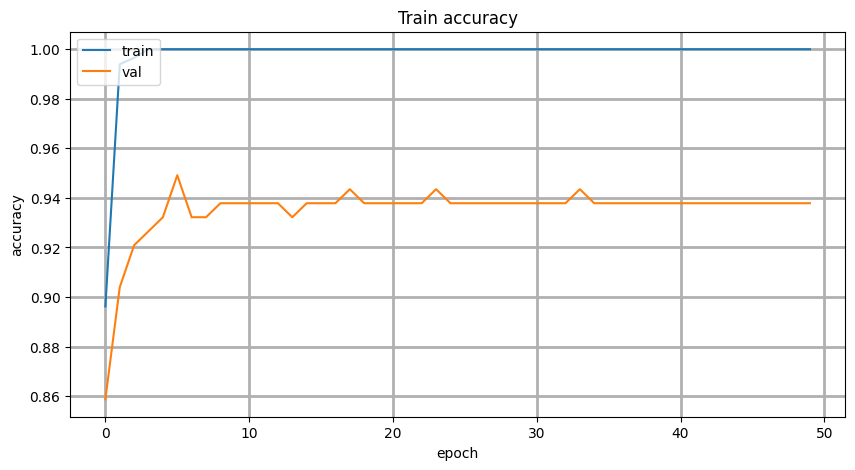

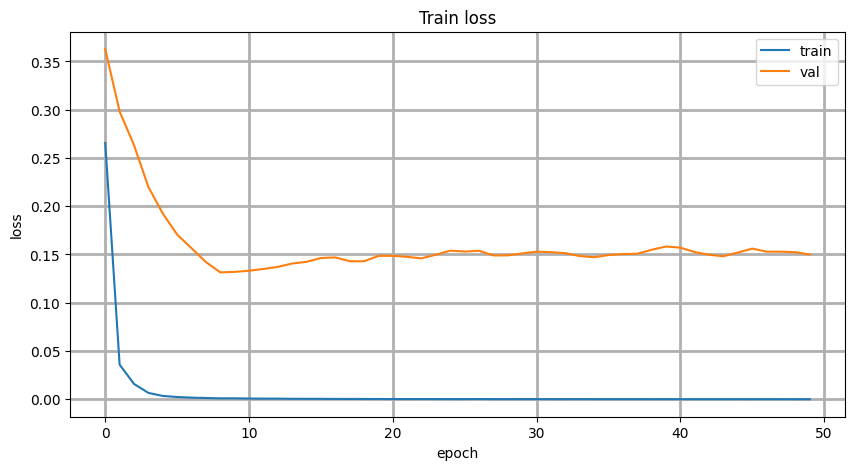

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history9.history['acc'])
plt.plot(history9.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history9.history['loss'])
plt.plot(history9.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model9.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - acc: 0.9984 - loss: 0.0075


[0.01807456649839878, 0.994350254535675]

In [ ]:
#save model9
model9.save('/content/drive/MyDrive/DADS_Deep Learning/Final_Project/save_model/B_16_Model9_1.h5')

6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       123
           1       0.96      1.00      0.98        54

    accuracy                           0.99       177
   macro avg       0.98      0.99      0.99       177
weighted avg       0.99      0.99      0.99       177



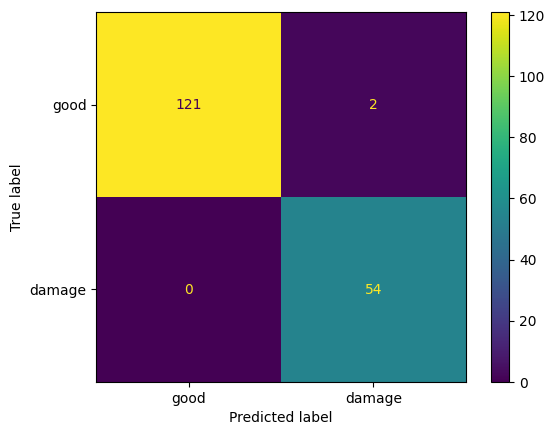

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
#y_pred = model.predict(x_test.reshape(-1, 784))
y_pred = model9.predict(x_test_vit)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_test_vit_encoded.argmax(axis=1)
# Confusion Matrix - rename variable to avoid overwriting the function
conf_matrix_result = confusion_matrix(y_true, y_pred_classes)
#print("Confusion Matrix:\n", conf_matrix_result)
# Classification Report
class_report = classification_report(y_true, y_pred_classes)
print("Classification Report:\n", class_report)
# Use the result of the confusion_matrix call, not the function itself
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix_result, display_labels = ["good","damage"])
cm_display.plot()
plt.show()

###Round 3


In [ ]:
# Classifier head
# Add Dense layers
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
bn_512 = tf.keras.layers.BatchNormalization(name='bn_512')(dense_512)
dropout5 = tf.keras.layers.Dropout(0.25)(bn_512)

dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(dropout5)
bn_256 = tf.keras.layers.BatchNormalization(name='bn_256')(dense_256)
dropout6 = tf.keras.layers.Dropout(0.25)(bn_256)

cls_outputs_m8 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m8')(dropout6)

# Construct the model
model8 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m8])
model8.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 197, 768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_1 (GetItem)                 │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_512 (BatchNormalization)          │ (None, 512)                 │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_256 (BatchNormalization)          │ (None, 256)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m8 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 528,642 (2.02 MB)

 Trainable params: 527,106 (2.01 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [ ]:
model8.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Evaluate the model BEFORE finetuning
model8.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - acc: 0.4874 - loss: 0.7041


[0.6971191167831421, 0.5310734510421753]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history8 = model8.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 36s 419ms/step - acc: 0.7980 - loss: 0.4843 - val_acc: 0.8023 - val_loss: 0.4156
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - acc: 0.9846 - loss: 0.0565 - val_acc: 0.9096 - val_loss: 0.3454
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - acc: 0.9965 - loss: 0.0180 - val_acc: 0.9096 - val_loss: 0.2978
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - acc: 1.0000 - loss: 0.0086 - val_acc: 0.9266 - val_loss: 0.2567
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - acc: 1.0000 - loss: 0.0043 - val_acc: 0.9322 - val_loss: 0.2223
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - acc: 1.0000 - loss: 0.0031 - val_acc: 0.9379 - val_loss: 0.2093
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - acc: 1.0000 - loss: 0.0023 - val_acc: 0.9379 - val_loss: 0.1844
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - acc: 1.0000 - loss: 0.0018 - val_acc: 0.9322 - val_loss: 0.1734
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - a

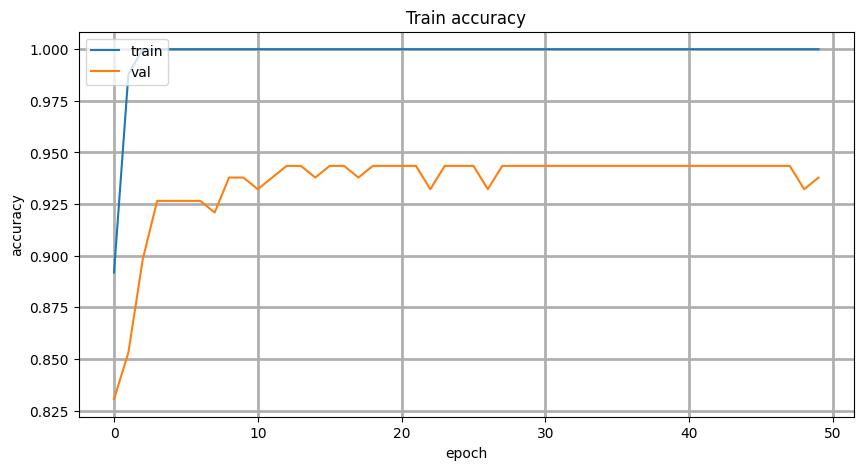

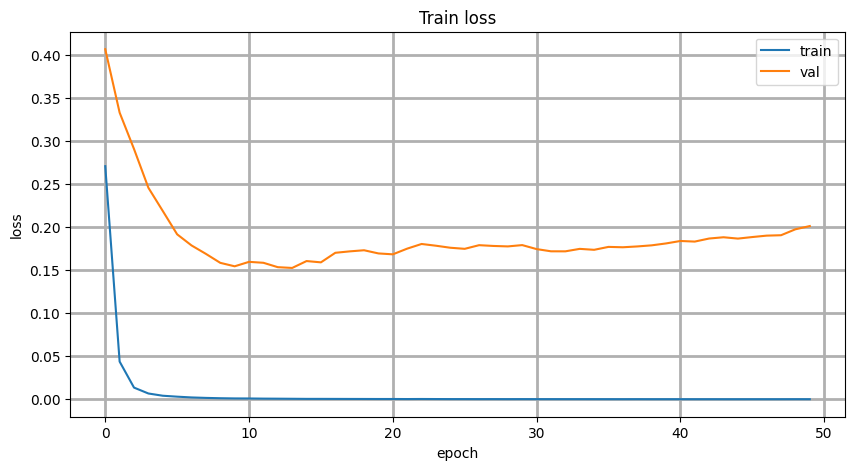

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history8.history['acc'])
plt.plot(history8.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history8.history['loss'])
plt.plot(history8.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model8.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - acc: 0.9924 - loss: 0.0288


[0.03594590350985527, 0.9887005686759949]

In [ ]:

#save model8
model8.save('/content/drive/MyDrive/DADS_Deep Learning/Final_Project/save_model_2/Best.h5')


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       123
           1       1.00      0.94      0.97        54

    accuracy                           0.98       177
   macro avg       0.99      0.97      0.98       177
weighted avg       0.98      0.98      0.98       177



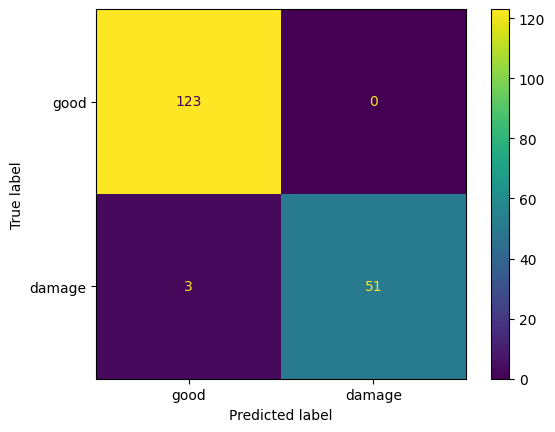

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

#y_pred = model.predict(x_test.reshape(-1, 784))
y_pred = model8.predict(x_test_vit)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_test_vit_encoded.argmax(axis=1)

# Confusion Matrix - rename variable to avoid overwriting the function
conf_matrix_result = confusion_matrix(y_true, y_pred_classes)
#print("Confusion Matrix:\n", conf_matrix_result)

# Classification Report
class_report = classification_report(y_true, y_pred_classes)
print("Classification Report:\n", class_report)

# Use the result of the confusion_matrix call, not the function itself
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix_result, display_labels = ["good","damage"])

cm_display.plot()
plt.show()